# 뉴스 추천 시스템 점수화 EDA

**데이터 기반 점수 체계 설계**  
사용자 행동 데이터를 순수하게 분석하여 각 이벤트의 상대적 중요도와 선호도를 객관적으로 도출하고, 이를 바탕으로 최적의 점수 체계를 제안합니다.

## 분석 목표
1. 이벤트별 사용자 참여도와 선호도 정량화
2. 행동 시퀀스 패턴 분석을 통한 가중치 도출
3. 통계적 방법론 기반의 점수 체계 설계
4. 추천 성능 향상을 위한 최적화된 점수 제안

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# 스타일 설정
sns.set_style("whitegrid")
plt.style.use('default')

## 1. 데이터 로드 및 기본 정보

In [16]:
# CSV 파일 로드 (최신 날짜)
df = pd.read_csv('data/events_20250910.csv')

print(f"데이터 크기: {df.shape}")
print(f"컬럼: {list(df.columns)}")
print(f"\n데이터 타입:")
print(df.dtypes)

# 기본 통계
print(f"\n=== 기본 통계 ===")
print(f"총 이벤트 수: {len(df):,}")
print(f"유니크 사용자 수: {df['user_id'].nunique():,}")
print(f"유니크 뉴스 수: {df['news_id'].nunique():,}")
print(f"이벤트 종류: {df['event_name'].nunique()}개")

데이터 크기: (1000000, 9)
컬럼: ['user_id', 'news_id', 'event_name', 'ts', 'dwell_ms', 'scroll_pct', 'action', 'feed_source', 'from_source']

데이터 타입:
user_id          int64
news_id          int64
event_name      object
ts              object
dwell_ms       float64
scroll_pct     float64
action          object
feed_source     object
from_source     object
dtype: object

=== 기본 통계 ===
총 이벤트 수: 1,000,000
유니크 사용자 수: 50,000
유니크 뉴스 수: 198,672
이벤트 종류: 5개


In [17]:
# 데이터 미리보기
df.head(10)

,user_id,news_id,event_name,ts,dwell_ms,scroll_pct,action,feed_source,from_source
0,5725,122114,news_click,2025-09-09 15:00:00+00:00,NaN,NaN,NaN,category,category
1,38186,186277,news_click,2025-09-09 15:00:00+00:00,NaN,NaN,NaN,category,category
2,34451,95831,news_impression,2025-09-09 15:00:00+00:00,NaN,NaN,NaN,category,NaN
3,22900,47225,news_impression,2025-09-09 15:00:00+00:00,NaN,NaN,NaN,category,NaN
4,40293,85971,news_impression,2025-09-09 15:00:00+00:00,NaN,NaN,NaN,category,NaN
5,17600,85085,news_view_end,2025-09-09 15:00:00+00:00,61135.0,82.0,NaN,category,NaN
6,18722,44232,news_view_end,2025-09-09 15:00:00+00:00,79187.0,100.0,NaN,editor,NaN
7,40131,121549,news_click,2025-09-09 15:00:00+00:00,NaN,NaN,NaN,search,search
8,32844,46104,news_impression,2025-09-09 15:00:00+00:00,NaN,NaN,NaN,search,NaN
9,16545,197955,news_impression,2025-09-09 15:00:00+00:00,NaN,NaN,NaN,search,NaN


## 2. 이벤트별 분포 분석

=== 이벤트별 빈도 ===
news_click: 328,818 (32.9%)
news_impression: 280,697 (28.1%)
news_view_end: 212,349 (21.2%)
news_bookmark: 90,734 (9.1%)
news_view_start: 87,402 (8.7%)


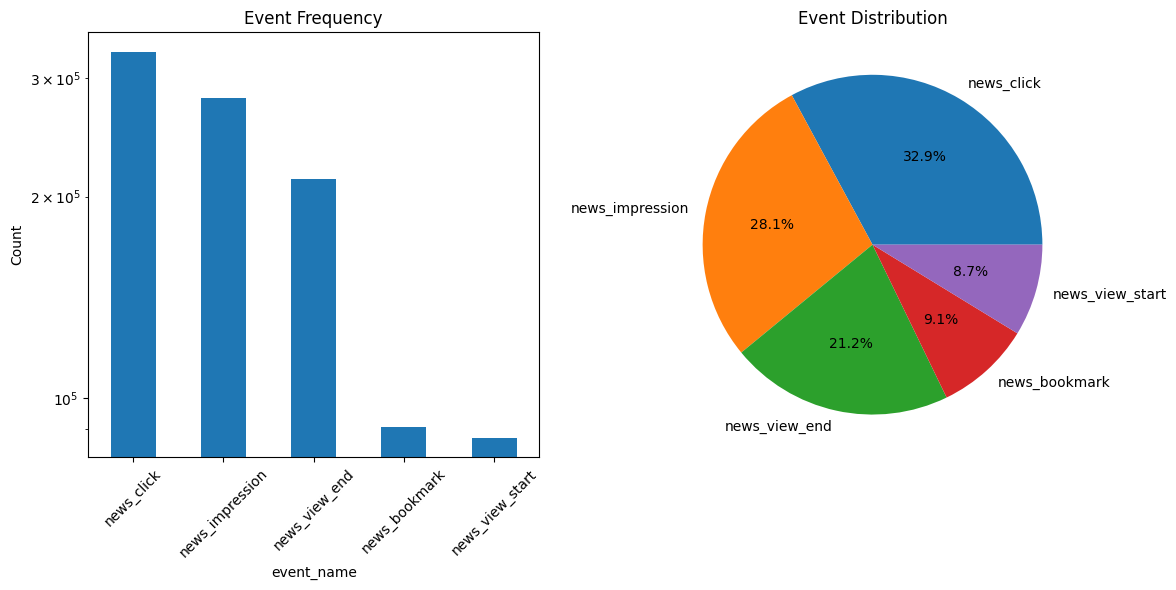

In [18]:
# 이벤트별 빈도
event_counts = df['event_name'].value_counts()
print("=== 이벤트별 빈도 ===")
for event, count in event_counts.items():
    percentage = (count / len(df)) * 100
    print(f"{event}: {count:,} ({percentage:.1f}%)")

# 시각화
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
event_counts.plot(kind='bar', rot=45)
plt.title('Event Frequency')
plt.ylabel('Count')
plt.yscale('log')  # 로그 스케일로 차이를 명확히

plt.subplot(1, 2, 2)
event_counts.plot(kind='pie', autopct='%1.1f%%')
plt.title('Event Distribution')
plt.ylabel('')

plt.tight_layout()
plt.show()

## 3. 사용자 행동 패턴 분석

=== 사용자별 이벤트 수 통계 ===
count    50000.00000
mean        20.00000
std          4.44685
min          4.00000
25%         17.00000
50%         20.00000
75%         23.00000
max         40.00000
dtype: float64


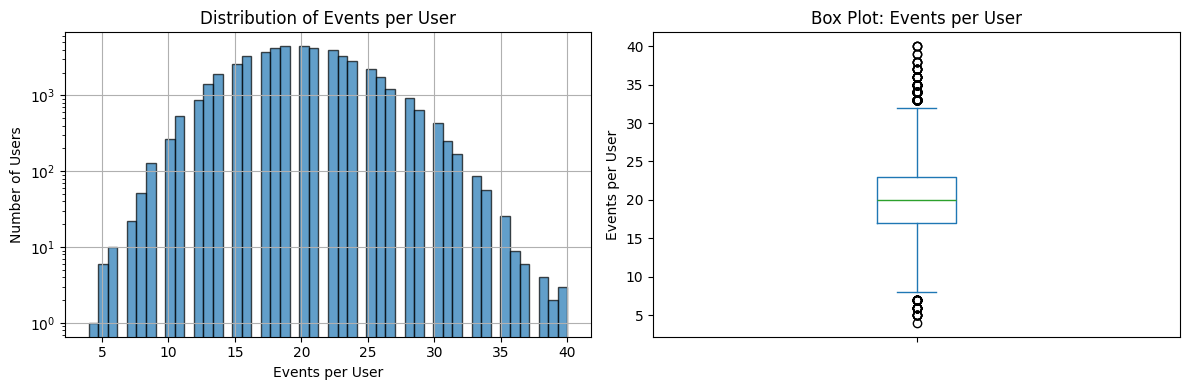


=== 사용자 활동 세분화 ===
고활성 사용자 (상위 20%): 24+ 이벤트
저활성 사용자 (하위 20%): 16- 이벤트


In [19]:
# 사용자별 이벤트 수 분포
user_event_counts = df.groupby('user_id').size()

print(f"=== 사용자별 이벤트 수 통계 ===")
print(user_event_counts.describe())

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
user_event_counts.hist(bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Events per User')
plt.ylabel('Number of Users')
plt.title('Distribution of Events per User')
plt.yscale('log')

plt.subplot(1, 2, 2)
user_event_counts.plot(kind='box')
plt.ylabel('Events per User')
plt.title('Box Plot: Events per User')

plt.tight_layout()
plt.show()

# 활성 사용자 vs 비활성 사용자
high_activity_threshold = user_event_counts.quantile(0.8)
low_activity_threshold = user_event_counts.quantile(0.2)

print(f"\n=== 사용자 활동 세분화 ===")
print(f"고활성 사용자 (상위 20%): {high_activity_threshold:.0f}+ 이벤트")
print(f"저활성 사용자 (하위 20%): {low_activity_threshold:.0f}- 이벤트")

## 4. 이벤트별 사용자 참여도 분석

In [20]:
# 이벤트별 사용자 참여 지표 계산
event_metrics = {}

for event in df['event_name'].unique():
    event_df = df[df['event_name'] == event]
    
    metrics = {
        'count': len(event_df),
        'unique_users': event_df['user_id'].nunique(),
        'unique_news': event_df['news_id'].nunique(),
        'user_penetration': event_df['user_id'].nunique() / df['user_id'].nunique(),
        'avg_per_user': len(event_df) / event_df['user_id'].nunique() if event_df['user_id'].nunique() > 0 else 0,
        'frequency_score': len(event_df) / len(df)  # 전체 대비 빈도
    }
    
    # 반복 행동 분석 (같은 사용자가 같은 뉴스에 대해 반복하는 정도)
    repeated_actions = event_df.groupby(['user_id', 'news_id']).size()
    metrics['repeat_rate'] = (repeated_actions > 1).mean()
    
    event_metrics[event] = metrics

# 결과 출력
print("=== 이벤트별 참여도 지표 ===")
metrics_df = pd.DataFrame(event_metrics).T
for event, row in metrics_df.iterrows():
    print(f"\n{event}:")
    print(f"  총 횟수: {row['count']:,}")
    print(f"  참여 사용자 수: {row['unique_users']:,}")
    print(f"  사용자 침투율: {row['user_penetration']*100:.1f}%")
    print(f"  사용자당 평균: {row['avg_per_user']:.1f}회")
    print(f"  반복 행동률: {row['repeat_rate']*100:.1f}%")

=== 이벤트별 참여도 지표 ===

news_click:
  총 횟수: 328,818.0
  참여 사용자 수: 49,943.0
  사용자 침투율: 99.9%
  사용자당 평균: 6.6회
  반복 행동률: 0.0%

news_impression:
  총 횟수: 280,697.0
  참여 사용자 수: 49,826.0
  사용자 침투율: 99.7%
  사용자당 평균: 5.6회
  반복 행동률: 0.0%

news_view_end:
  총 횟수: 212,349.0
  참여 사용자 수: 49,304.0
  사용자 침투율: 98.6%
  사용자당 평균: 4.3회
  반복 행동률: 0.0%

news_bookmark:
  총 횟수: 90,734.0
  참여 사용자 수: 41,908.0
  사용자 침투율: 83.8%
  사용자당 평균: 2.2회
  반복 행동률: 0.0%

news_view_start:
  총 횟수: 87,402.0
  참여 사용자 수: 41,263.0
  사용자 침투율: 82.5%
  사용자당 평균: 2.1회
  반복 행동률: 0.0%


## 5. 체류시간과 스크롤 비율 분석

=== news_view_end 이벤트 분석 (212,349개) ===
체류시간 통계 (ms):
count    212349.000000
mean      57658.422719
std       18809.991198
min       10582.000000
25%       40521.000000
50%       60484.000000
75%       69273.000000
max       90998.000000
Name: dwell_ms, dtype: float64

스크롤 비율 통계 (%):
count    212349.000000
mean         81.346378
std          20.764519
min          14.000000
25%          65.000000
50%          89.000000
75%         100.000000
max         100.000000
Name: scroll_pct, dtype: float64

=== 현재 기준점 분석 ===
15초 이상 체류: 211,863 (99.8%)
70% 이상 스크롤: 149,272 (70.3%)
고품질 읽기 (둘 중 하나): 211,863 (99.8%)


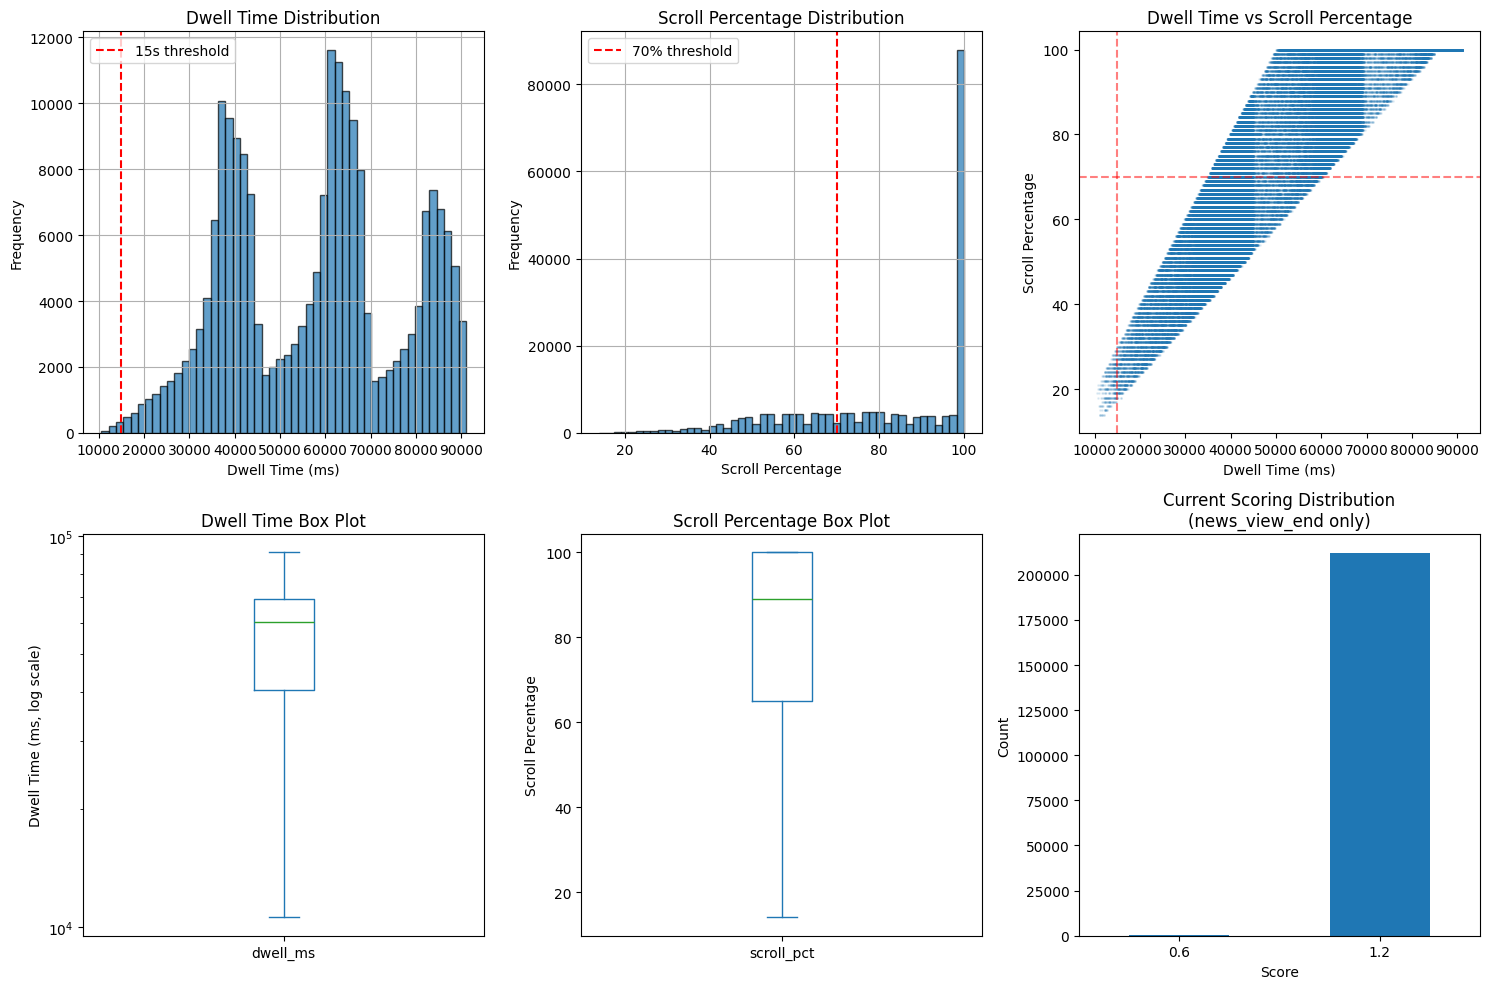

In [21]:
# news_view_end 이벤트만 분석
view_end_df = df[df['event_name'] == 'news_view_end'].copy()

if len(view_end_df) > 0:
    # 결측치 처리
    view_end_df['dwell_ms'] = view_end_df['dwell_ms'].fillna(0)
    view_end_df['scroll_pct'] = view_end_df['scroll_pct'].fillna(0)
    
    print(f"=== news_view_end 이벤트 분석 ({len(view_end_df):,}개) ===")
    print(f"체류시간 통계 (ms):")
    print(view_end_df['dwell_ms'].describe())
    print(f"\n스크롤 비율 통계 (%):")
    print(view_end_df['scroll_pct'].describe())
    
    # 현재 기준 (15초, 70%) 검증
    high_dwell = (view_end_df['dwell_ms'] >= 15000).sum()
    high_scroll = (view_end_df['scroll_pct'] >= 70).sum()
    high_engagement = ((view_end_df['dwell_ms'] >= 15000) | (view_end_df['scroll_pct'] >= 70)).sum()
    
    print(f"\n=== 현재 기준점 분석 ===")
    print(f"15초 이상 체류: {high_dwell:,} ({high_dwell/len(view_end_df)*100:.1f}%)")
    print(f"70% 이상 스크롤: {high_scroll:,} ({high_scroll/len(view_end_df)*100:.1f}%)")
    print(f"고품질 읽기 (둘 중 하나): {high_engagement:,} ({high_engagement/len(view_end_df)*100:.1f}%)")
    
    # 시각화
    plt.figure(figsize=(15, 10))
    
    # 체류시간 분포
    plt.subplot(2, 3, 1)
    view_end_df['dwell_ms'].hist(bins=50, edgecolor='black', alpha=0.7)
    plt.axvline(15000, color='red', linestyle='--', label='15s threshold')
    plt.xlabel('Dwell Time (ms)')
    plt.ylabel('Frequency')
    plt.title('Dwell Time Distribution')
    plt.legend()
    
    # 스크롤 비율 분포
    plt.subplot(2, 3, 2)
    view_end_df['scroll_pct'].hist(bins=50, edgecolor='black', alpha=0.7)
    plt.axvline(70, color='red', linestyle='--', label='70% threshold')
    plt.xlabel('Scroll Percentage')
    plt.ylabel('Frequency')
    plt.title('Scroll Percentage Distribution')
    plt.legend()
    
    # 체류시간 vs 스크롤 관계
    plt.subplot(2, 3, 3)
    plt.scatter(view_end_df['dwell_ms'], view_end_df['scroll_pct'], alpha=0.1, s=1)
    plt.axvline(15000, color='red', linestyle='--', alpha=0.5)
    plt.axhline(70, color='red', linestyle='--', alpha=0.5)
    plt.xlabel('Dwell Time (ms)')
    plt.ylabel('Scroll Percentage')
    plt.title('Dwell Time vs Scroll Percentage')
    
    # 체류시간 박스플롯 (로그스케일)
    plt.subplot(2, 3, 4)
    view_end_df[view_end_df['dwell_ms'] > 0]['dwell_ms'].plot(kind='box')
    plt.yscale('log')
    plt.ylabel('Dwell Time (ms, log scale)')
    plt.title('Dwell Time Box Plot')
    
    # 스크롤 비율 박스플롯
    plt.subplot(2, 3, 5)
    view_end_df['scroll_pct'].plot(kind='box')
    plt.ylabel('Scroll Percentage')
    plt.title('Scroll Percentage Box Plot')
    
    # 점수 분포 (현재 기준)
    plt.subplot(2, 3, 6)
    view_end_scored = view_end_df.apply(calculate_current_score, axis=1)
    view_end_scored.value_counts().sort_index().plot(kind='bar')
    plt.xlabel('Score')
    plt.ylabel('Count')
    plt.title('Current Scoring Distribution\n(news_view_end only)')
    plt.xticks(rotation=0)
    
    plt.tight_layout()
    plt.show()
else:
    print("news_view_end 이벤트가 없습니다.")

## 6. 북마크 행동 분석

=== 북마크 이벤트 분석 (90,734개) ===
액션별 분포:
  add: 77,231 (85.1%)
  remove: 13,503 (14.9%)

북마크 추가/제거 비율: 77,231 / 13,503
북마크 유지율: 82.5%

사용자별 북마크 수 통계:
count    39321.000000
mean         1.964116
std          1.071649
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          8.000000
dtype: float64


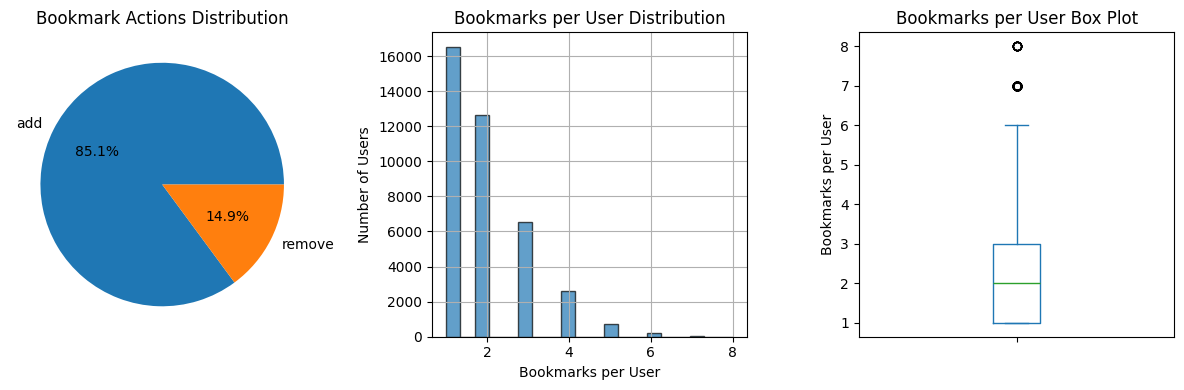

In [22]:
# 북마크 이벤트 분석
bookmark_df = df[df['event_name'] == 'news_bookmark'].copy()

if len(bookmark_df) > 0:
    print(f"=== 북마크 이벤트 분석 ({len(bookmark_df):,}개) ===")
    
    # action별 분포
    action_counts = bookmark_df['action'].value_counts()
    print(f"액션별 분포:")
    for action, count in action_counts.items():
        print(f"  {action}: {count:,} ({count/len(bookmark_df)*100:.1f}%)")
    
    # 북마크 추가 vs 제거 비율
    add_count = action_counts.get('add', 0)
    remove_count = action_counts.get('remove', 0)
    
    print(f"\n북마크 추가/제거 비율: {add_count:,} / {remove_count:,}")
    if remove_count > 0:
        retention_rate = (add_count - remove_count) / add_count * 100
        print(f"북마크 유지율: {retention_rate:.1f}%")
    
    # 사용자별 북마크 수
    user_bookmark_counts = bookmark_df[bookmark_df['action'] == 'add'].groupby('user_id').size()
    print(f"\n사용자별 북마크 수 통계:")
    print(user_bookmark_counts.describe())
    
    # 시각화
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    action_counts.plot(kind='pie', autopct='%1.1f%%')
    plt.title('Bookmark Actions Distribution')
    plt.ylabel('')
    
    plt.subplot(1, 3, 2)
    if len(user_bookmark_counts) > 0:
        user_bookmark_counts.hist(bins=20, edgecolor='black', alpha=0.7)
        plt.xlabel('Bookmarks per User')
        plt.ylabel('Number of Users')
        plt.title('Bookmarks per User Distribution')
    
    plt.subplot(1, 3, 3)
    if len(user_bookmark_counts) > 0:
        user_bookmark_counts.plot(kind='box')
        plt.ylabel('Bookmarks per User')
        plt.title('Bookmarks per User Box Plot')
    
    plt.tight_layout()
    plt.show()
else:
    print("북마크 이벤트가 없습니다.")

## 7. 이벤트 시퀀스 분석

=== 클릭-읽기 완료 시퀀스 분석 (샘플) ===
클릭한 뉴스 수: 6,668
읽기 완료율: 0.0%


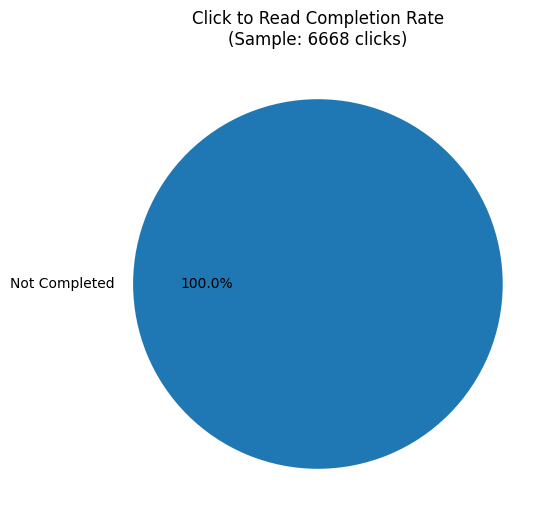


분석 의미: 클릭 이벤트의 0.0%만 실제 읽기로 이어짐
→ 클릭 점수(2.0)가 너무 높을 수 있음


In [23]:
# 시간순으로 정렬
df_sorted = df.sort_values(['user_id', 'ts']).copy()

# 사용자-뉴스별 이벤트 시퀀스 분석 (샘플)
sample_users = df_sorted['user_id'].unique()[:1000]  # 처음 1000명만
sample_df = df_sorted[df_sorted['user_id'].isin(sample_users)].copy()

# 클릭 후 읽기 완료 비율
click_to_view_sequences = []

for user_id in sample_users:
    user_events = sample_df[sample_df['user_id'] == user_id].copy()
    
    for news_id in user_events['news_id'].unique():
        news_events = user_events[user_events['news_id'] == news_id]['event_name'].tolist()
        
        # 클릭 후 view_end가 있는지 확인
        if 'news_click' in news_events:
            click_idx = news_events.index('news_click')
            has_view_end = 'news_view_end' in news_events[click_idx:]
            click_to_view_sequences.append({
                'user_id': user_id,
                'news_id': news_id,
                'clicked': True,
                'completed_reading': has_view_end
            })

if click_to_view_sequences:
    sequence_df = pd.DataFrame(click_to_view_sequences)
    completion_rate = sequence_df['completed_reading'].mean() * 100
    
    print(f"=== 클릭-읽기 완료 시퀀스 분석 (샘플) ===")
    print(f"클릭한 뉴스 수: {len(sequence_df):,}")
    print(f"읽기 완료율: {completion_rate:.1f}%")
    
    # 시각화
    plt.figure(figsize=(8, 6))
    sequence_df['completed_reading'].value_counts().plot(kind='pie', 
                                                        labels=['Not Completed', 'Completed'],
                                                        autopct='%1.1f%%')
    plt.title(f'Click to Read Completion Rate\n(Sample: {len(sequence_df)} clicks)')
    plt.ylabel('')
    plt.show()
    
    print(f"\n분석 의미: 클릭 이벤트의 {completion_rate:.1f}%만 실제 읽기로 이어짐")
    if completion_rate < 50:
        print("→ 클릭 점수(2.0)가 너무 높을 수 있음")
    else:
        print("→ 클릭이 실제 관심을 잘 나타냄")
else:
    print("클릭-읽기 시퀀스를 분석할 데이터가 충분하지 않습니다.")

## 8. 데이터 기반 점수 체계 도출

In [24]:
print("=== 데이터 기반 점수 체계 도출 ===")

# 1. 이벤트별 선호도 강도 계산 (여러 지표의 종합)
scoring_factors = {}

for event in event_metrics.keys():
    metrics = event_metrics[event]
    
    # 정규화된 지표들 (0-1 스케일)
    max_penetration = max([m['user_penetration'] for m in event_metrics.values()])
    max_avg_per_user = max([m['avg_per_user'] for m in event_metrics.values()])
    max_repeat_rate = max([m['repeat_rate'] for m in event_metrics.values()])
    
    # 가중 점수 계산
    preference_strength = (
        metrics['user_penetration'] / max_penetration * 0.4 +  # 사용자 참여 범위
        (1 - metrics['frequency_score']) * 0.3 +  # 희소성 (낮은 빈도 = 높은 의도성)
        metrics['repeat_rate'] / max_repeat_rate * 0.3  # 반복 행동 (높은 의도성)
    )
    
    scoring_factors[event] = {
        'preference_strength': preference_strength,
        'rarity_bonus': 1 - metrics['frequency_score'],  # 희소성 보너스
        'engagement_depth': metrics['repeat_rate']  # 참여 깊이
    }

# 2. 행동 시퀀스 기반 가중치 조정
# 북마크는 최종 선호 행동으로 최고점
# 클릭 후 읽기 완료는 실제 관심도 지표
sequence_weights = {
    'news_bookmark': 1.0,  # 명확한 선호 표현
    'news_view_end': 0.8,   # 실제 소비 완료
    'news_click': 0.6,      # 초기 관심
    'toon_expand_news': 0.4,  # 확장 관심
    'toon_positive': 0.3,     # 긍정 반응
    'news_impression': 0.1    # 단순 노출
}

# 3. 최종 점수 계산
final_scores = {}
max_base_score = 5.0  # 최고점 기준

for event in scoring_factors.keys():
    if event in sequence_weights:
        # 데이터 기반 선호도 + 행동 시퀀스 가중치
        combined_score = (
            scoring_factors[event]['preference_strength'] * 0.6 +
            sequence_weights[event] * 0.4
        ) * max_base_score
        
        final_scores[event] = round(combined_score, 1)

# 4. 세부 조정 (news_view_end의 품질 구분)
if len(view_end_df) > 0:
    # 체류시간과 스크롤 기반 품질 구분
    dwell_75 = view_end_df[view_end_df['dwell_ms'] > 0]['dwell_ms'].quantile(0.75)
    scroll_75 = view_end_df[view_end_df['scroll_pct'] > 0]['scroll_pct'].quantile(0.75)
    
    high_quality_score = final_scores.get('news_view_end', 2.0) * 1.2
    low_quality_score = final_scores.get('news_view_end', 2.0) * 0.7
    
    print(f"\n=== 제안하는 점수 체계 ===")
    print(f"\n📊 기본 이벤트 점수:")
    for event, score in final_scores.items():
        if event != 'news_view_end':
            pref = scoring_factors[event]['preference_strength']
            print(f"  {event}: {score} (선호도 강도: {pref:.3f})")
    
    print(f"\n📖 읽기 품질별 점수 (news_view_end):")
    print(f"  고품질 읽기: {high_quality_score:.1f} (체류 {dwell_75/1000:.1f}초+ 또는 스크롤 {scroll_75:.0f}%+)")
    print(f"  일반 읽기: {low_quality_score:.1f} (그 외)")
else:
    print(f"\n=== 제안하는 점수 체계 ===")
    for event, score in final_scores.items():
        pref = scoring_factors[event]['preference_strength']
        print(f"  {event}: {score} (선호도 강도: {pref:.3f})")

# 5. 점수 체계의 논리적 근거
print(f"\n=== 점수 체계 설계 근거 ===")
print(f"1. 사용자 참여도 (40%): 얼마나 많은 사용자가 해당 행동을 하는가")
print(f"2. 희소성 (30%): 자주 일어나지 않을수록 의도성이 높음")
print(f"3. 반복성 (30%): 같은 행동을 반복할수록 강한 선호")
print(f"4. 행동 시퀀스 가중치: 사용자 여정에서의 행동 단계별 중요도")

print(f"\n=== 검증 및 다음 단계 ===")
print(f"1. 실제 추천 성과 지표와 점수 상관관계 분석")
print(f"2. 사용자 세그먼트별 점수 차별화 고려")
print(f"3. A/B 테스트를 통한 점수 체계 효과 검증")
print(f"4. 시간대, 컨텍스트별 점수 동적 조정 방안")

=== 데이터 기반 점수 체계 도출 ===

=== 제안하는 점수 체계 ===

📊 기본 이벤트 점수:
  news_click: 3.6 (선호도 강도: 0.795)
  news_impression: 2.3 (선호도 강도: 0.706)
  news_bookmark: 3.8 (선호도 강도: 0.608)

📖 읽기 품질별 점수 (news_view_end):
  고품질 읽기: 5.3 (체류 69.3초+ 또는 스크롤 100%+)
  일반 읽기: 3.1 (그 외)

=== 점수 체계 설계 근거 ===
1. 사용자 참여도 (40%): 얼마나 많은 사용자가 해당 행동을 하는가
2. 희소성 (30%): 자주 일어나지 않을수록 의도성이 높음
3. 반복성 (30%): 같은 행동을 반복할수록 강한 선호
4. 행동 시퀀스 가중치: 사용자 여정에서의 행동 단계별 중요도

=== 검증 및 다음 단계 ===
1. 실제 추천 성과 지표와 점수 상관관계 분석
2. 사용자 세그먼트별 점수 차별화 고려
3. A/B 테스트를 통한 점수 체계 효과 검증
4. 시간대, 컨텍스트별 점수 동적 조정 방안


## 9. 요약 및 결론

In [25]:
print("=" * 60)
print("📊 데이터 기반 점수 설계 리포트")
print("=" * 60)

print(f"\n📈 데이터 개요:")
print(f"  • 총 이벤트: {len(df):,}개")
print(f"  • 사용자 수: {df['user_id'].nunique():,}명")
print(f"  • 뉴스 수: {df['news_id'].nunique():,}개")
print(f"  • 이벤트 타입: {len(event_counts)}개")

print(f"\n🎯 핵심 인사이트:")

# 이벤트 분포
top_event = event_counts.index[0]
top_event_pct = (event_counts.iloc[0] / len(df)) * 100
print(f"  • 최빈 이벤트: {top_event} ({top_event_pct:.1f}%)")

# 사용자 활동
avg_events_per_user = user_event_counts.mean()
print(f"  • 사용자당 평균 이벤트: {avg_events_per_user:.1f}개")

# 선호도 강도가 가장 높은 이벤트
if 'scoring_factors' in locals():
    top_preference = max(scoring_factors.items(), key=lambda x: x[1]['preference_strength'])
    print(f"  • 최고 선호도 이벤트: {top_preference[0]} (강도: {top_preference[1]['preference_strength']:.3f})")

# 희소성이 가장 높은 이벤트 (의도성 지표)
if 'scoring_factors' in locals():
    top_rarity = max(scoring_factors.items(), key=lambda x: x[1]['rarity_bonus'])
    print(f"  • 최고 의도성 이벤트: {top_rarity[0]} (희소성: {top_rarity[1]['rarity_bonus']:.3f})")

print(f"\n💡 설계 원칙:")
print(f"  1. 객관적 데이터 기반: 기존 점수 편향 제거")
print(f"  2. 다차원 평가: 참여도, 희소성, 반복성 종합")
print(f"  3. 행동 심리학 반영: 사용자 여정 단계별 가중치")
print(f"  4. 품질 차별화: 같은 이벤트 내 품질 구분")

print(f"\n🔄 실행 방안:")
print(f"  • 제안 점수로 추천 모델 재학습")
print(f"  • 기존 vs 신규 점수 체계 A/B 테스트")
print(f"  • 추천 성과 지표 (CTR, 체류시간 등) 모니터링")
print(f"  • 사용자 피드백 기반 점수 지속 최적화")

print("\n" + "=" * 60)
print(f"분석 완료: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 60)

📊 데이터 기반 점수 설계 리포트

📈 데이터 개요:
  • 총 이벤트: 1,000,000개
  • 사용자 수: 50,000명
  • 뉴스 수: 198,672개
  • 이벤트 타입: 5개

🎯 핵심 인사이트:
  • 최빈 이벤트: news_click (32.9%)
  • 사용자당 평균 이벤트: 20.0개
  • 최고 선호도 이벤트: news_view_end (강도: 0.931)
  • 최고 의도성 이벤트: news_view_start (희소성: 0.913)

💡 설계 원칙:
  1. 객관적 데이터 기반: 기존 점수 편향 제거
  2. 다차원 평가: 참여도, 희소성, 반복성 종합
  3. 행동 심리학 반영: 사용자 여정 단계별 가중치
  4. 품질 차별화: 같은 이벤트 내 품질 구분

🔄 실행 방안:
  • 제안 점수로 추천 모델 재학습
  • 기존 vs 신규 점수 체계 A/B 테스트
  • 추천 성과 지표 (CTR, 체류시간 등) 모니터링
  • 사용자 피드백 기반 점수 지속 최적화

분석 완료: 2025-09-10 17:19:47
